In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import plots

In [14]:
data_folder = 'data/'
data_file = '10101.csv'

useRaw = False
test_size = 0.2
seed = 13
window_size = 50
days = [0]
cat_matrix = True # True for neural net, any for random forest

In [15]:
df = features.load_features(data_folder + data_file)
df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.MEAN, features=["EEGv", "EMGv"])
df = df.dropna()
df = features.add_times(df)

df = features.filter_days(df, days)

skeep, _ = features.states(useRaw)
print(df[skeep].value_counts())
df.head(1)

w    11631
n     9104
r      816
Name: state, dtype: int64


,rawState,state,EEGv,EMGv,temp,EEGv_mean,EMGv_mean,time,day
49,w,w,2.976543e-09,7.784953e-10,0.0,3.147769e-09,2.602624e-09,49,0


In [16]:
x_train, x_test, y_train, y_test, le = features.split_data(df, useRaw, test_size, seed, cat_matrix)

# Neural Network

In [17]:
def baseline_model(input_dim, num_classes, lr=0.001):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 8)                 72        
                                                                 
 dense_4 (Dense)             (None, 3)                 27        
                                                                 
Total params: 387
Trainable params: 387
Non-trainable params: 0
_________________________________________________________________


2022-12-13 10:43:08.977059: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


100%|██████████| 25/25 [01:28<00:00,  3.53s/epoch, loss=0.17, accuracy=0.93, val_loss=0.195, val_accuracy=0.92]   


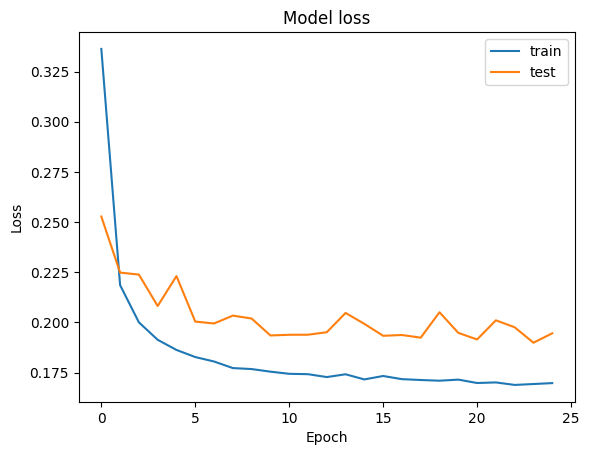

In [18]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=10,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_loss(history.history)

135/135 [==============================] - 0s 1ms/step
[[1668   28  101]
 [  64   37   69]
 [  53   32 2259]]
              precision    recall  f1-score   support

           n       0.93      0.93      0.93      1797
           r       0.38      0.22      0.28       170
           w       0.93      0.96      0.95      2344

    accuracy                           0.92      4311
   macro avg       0.75      0.70      0.72      4311
weighted avg       0.91      0.92      0.91      4311



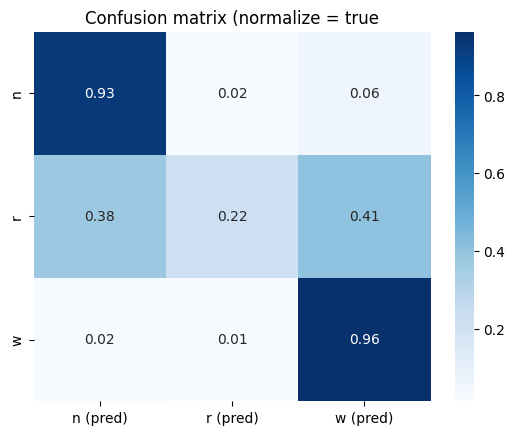

In [19]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')

# Random Forest

[[1729   13   55]
 [  94   45   31]
 [ 103   12 2229]]
              precision    recall  f1-score   support

           n       0.90      0.96      0.93      1797
           r       0.64      0.26      0.37       170
           w       0.96      0.95      0.96      2344

    accuracy                           0.93      4311
   macro avg       0.83      0.73      0.75      4311
weighted avg       0.92      0.93      0.92      4311



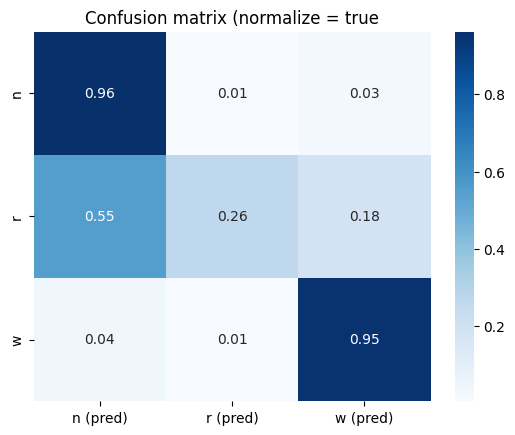

"Score": 0.9134771514729761


In [20]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')
print(f'\"Score\": {rfc.score(x_test, y_test)}')

# Ridge Regression

[[1599    0  198]
 [ 139    0   31]
 [ 376    0 1968]]
              precision    recall  f1-score   support

           n       0.76      0.89      0.82      1797
           r       0.00      0.00      0.00       170
           w       0.90      0.84      0.87      2344

    accuracy                           0.83      4311
   macro avg       0.55      0.58      0.56      4311
weighted avg       0.80      0.83      0.81      4311



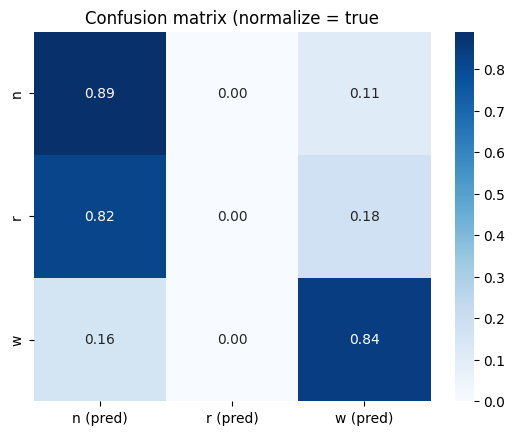

"Score": 0.8162839248434238


In [21]:
alphas=[1e-3, 1e-2, 1e-1, 1]

rrc = RidgeClassifierCV(alphas=alphas)
rrc.fit(x_train, y_train)
y_predict = rrc.predict(x_test)

plots.plot_confusion(model=rrc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')
print(f'\"Score\": {rrc.score(x_test, y_test)}')

# K-Nearest Neighbours

[[1704   33   60]
 [  94   31   45]
 [ 141   32 2171]]
              precision    recall  f1-score   support

           n       0.88      0.95      0.91      1797
           r       0.32      0.18      0.23       170
           w       0.95      0.93      0.94      2344

    accuracy                           0.91      4311
   macro avg       0.72      0.69      0.70      4311
weighted avg       0.90      0.91      0.90      4311



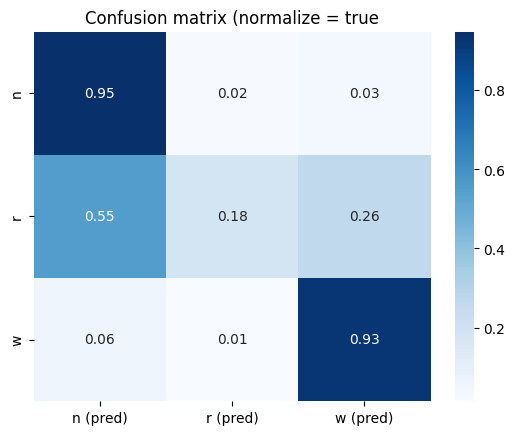

"Score": 0.8963117606123869


In [22]:
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(x_train, y_train)
y_predict = knn.predict(x_test)

plots.plot_confusion(model=knn, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')
print(f'\"Score\": {knn.score(x_test, y_test)}')

# Logistic Regression

[[1688    0  109]
 [ 103    0   67]
 [ 144    4 2196]]
              precision    recall  f1-score   support

           n       0.87      0.94      0.90      1797
           r       0.00      0.00      0.00       170
           w       0.93      0.94      0.93      2344

    accuracy                           0.90      4311
   macro avg       0.60      0.63      0.61      4311
weighted avg       0.87      0.90      0.88      4311



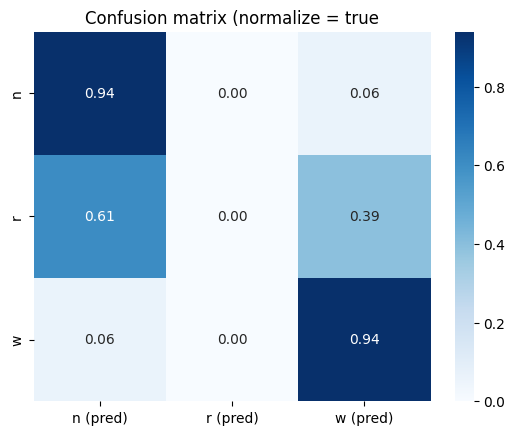

"Score": 0.9009510554395732


In [23]:
x_train, x_test, y_train, y_test, le = features.split_data(df, useRaw, test_size, seed, cat_matrix=False)

lrc = LogisticRegression(random_state=seed)
lrc.fit(x_train, y_train)
y_predict = lrc.predict(x_test)

plots.plot_confusion(model=lrc, x_test=x_test, y_test=y_test, le=le, cat_matrix=False, normalize='true')

print(f'\"Score\": {lrc.score(x_test, y_test)}')